# Descriptive analysis on the network

In [ ]:
import networkx as nx
from community import community_louvain
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast


In [ ]:
# Read the GraphML file
G = nx.read_graphml('synopsis_graph_final.graphml')

# Print the nodes and edges
print("Nodes:")
print(G.nodes(data=True)['1'])  # data=True to get node attributes as well

print("\nEdges:")
print(G.edges(data=True))  # data=True to get edge attributes as well

Nodes:
{'title': 'Last Vegas', 'genre': "['Comedy']", 'movie_id': 'tt1204975', 'plot_synopsis': 'Four boys around the age of 10 are friends in Brooklyn during the \'50s. They have a nickname, the Flatbush Four, and also pal around with a girl. One day they get into a scuffle at a store with a young thug, and steal a bottle of scotch as they run away.58 years later: Sam has retired with his wife to Naples, FL; Archie is living with his son in New Jersey; Paddy lives alone in Brooklyn after his wife Sophie died a year earlier; Billy is wealthy and living in Malibu, CA with a young woman named Lisa.Billy goes to the funeral for his friend Ronnie, and in the process of eulogizing him, while commenting on the shortness of life and love, he spontaneously proposes to Lisa.Billy conference calls Sam and Archie to tell them he is getting married that weekend in Las Vegas, and they not only want to come to the wedding, they want to throw him a bachelor party the night before. All three of them d

In [ ]:
# Find partition with Louvain algorithm
louvain_partition0 = community_louvain.best_partition(G, weight='weight', random_state=42)

# Add partition information as a node attribute
nx.set_node_attributes(G, louvain_partition0, 'community')

nodes= G.nodes(data = True)

## The adjacency matrix

<Axes: >

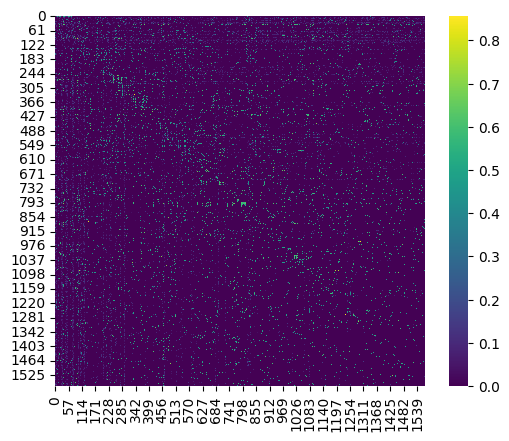

In [ ]:
A = nx.adjacency_matrix(G)
sns.heatmap(A.todense(),
             square=True,
             cmap = 'viridis')

### Basic Statistics

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G) #It is the ratio of the number of edges in the graph to the number of edges in a complete graph with the same number of nodes.
#It is a measure of how many edges are present in the network compared to the maximum number of possible edges.
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density:.4f}")

Number of nodes: 1572
Number of edges: 106054
Density: 0.0859


### Degree statistics

In [ ]:
degrees = dict(G.degree())


average_degree = sum(degrees.values()) / len(degrees)
print("Average Degree:", average_degree)
print("Standard Deviation:", np.std(list(degrees.values())))
print('Median Degree:', np.median(list(degrees.values())))
print("Minimum Degree:", min(degrees.values()))
print("Maximum Degree:", max(degrees.values()))

Average Degree: 134.92875318066157
Standard Deviation: 108.69108482919012
Median Degree: 101.0
Minimum Degree: 62
Maximum Degree: 884


- On average, each movie in the network is connected to about 134 other movies. his relatively high average degree indicates that movies in this network are highly interconnected, suggesting that there are many similarities or relationships between the plots of different movies.

- A standard deviation of 108.7 is very high, indicating a wide range of connectivity among the movies. Some movies are much more connected than others, which may suggest the presence of hubs or key movies that are central to the network.

- Half of the movies have a degree less than 101, and half have a degree greater than 101. The median is lower than the average degree, which usually indicates that the degree distribution is right-skewed. This means there are a few movies with very high degrees that are pulling the average up.

- Even the least connected movies are quite interconnected and there are no movies that are isolated or only minimally connected.

- This extremely high degree indicates the presence of super-hubs within the network. These hubs are likely to be very central movies that connect different parts of the network, possibly representing highly popular or genre-defining movies.

### Degree distribution

In [ ]:
df_nodes = pd.DataFrame(G.degree(), columns = ['node', 'degree'])

df_nodes.head()

node  degree
0    0      77
1   56     580
2   90     119
3   94     710
4  151     686

In [ ]:
degree_dist = df_nodes.groupby('degree').size().reset_index()
degree_dist

degree  0
0        62  1
1        64  1
2        65  2
3        67  2
4        68  1
..      ... ..
250     829  1
251     843  1
252     854  1
253     860  1
254     884  1

[255 rows x 2 columns]

In [ ]:
degree_dist.columns = ['k', 'nk']
degree_dist = degree_dist.sort_values('k', ascending = False)

# evaluate p(k) = N_k / N
degree_dist['pk'] = degree_dist['nk'] / G.number_of_nodes()

degree_dist.head()

k  nk        pk
254  884   1  0.000636
253  860   1  0.000636
252  854   1  0.000636
251  843   1  0.000636
250  829   1  0.000636

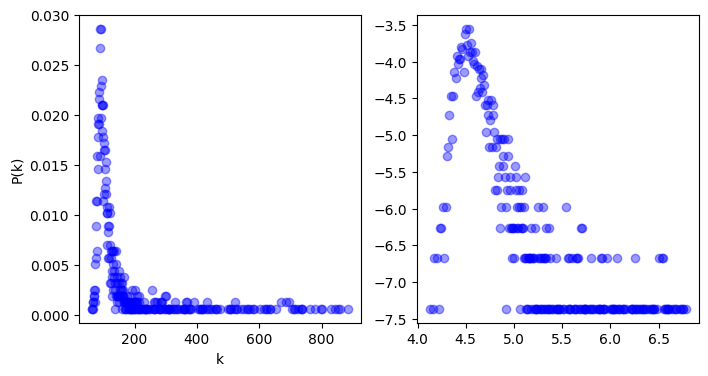

In [ ]:
# Power law distributions
fig, axs = plt.subplots(1,2, facecolor='w', figsize=(8,4))


axs[0].scatter(degree_dist['k'] ,degree_dist['pk'], color = 'b',alpha = 0.4)
axs[0].set_xlabel('k')

axs[0].set_ylabel('P(k)')

# change scale to log log
axs[1].scatter(np.log(degree_dist['k']) ,np.log(degree_dist['pk']), color = 'b',alpha = 0.4)


plt.show()

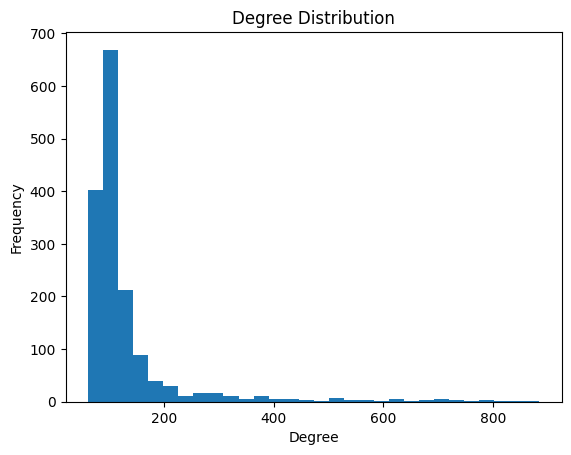

In [ ]:
degrees = [degree for node, degree in G.degree()]
plt.hist(degrees, bins=30)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

The histogram is heavily right-skewed, meaning most nodes (movies) have a relatively low degree, with a small number of nodes having a very high degree. This is indicative of a network where most movies are connected to a few other movies, but there are hub nodes, which are highly connected compared to the rest of the network. They could represent popular movies or movies that connect different genres.
The presence of a few highly connected nodes (hubs) and a large number of nodes with low connectivity suggests that the network might exhibit scale-free properties.

### Clustering coefficient

In [ ]:
clustering_coeffs = nx.clustering(G)
average_clustering = np.mean(list(clustering_coeffs.values()))

print(f"Average Clustering Coefficient: {average_clustering:.4f}")

Average Clustering Coefficient: 0.2327


The moderate clustering coefficient suggests the presence of communities  where movies are more interconnected. However, the connections are not extremely tight.

### Distances in the network

#### Average shortest path

In [ ]:
nx.average_shortest_path_length(G)

1.9141314506084357

#### Diameter: the maximum distance between any pair of nodes in the graph

In [ ]:
nx.diameter(G)

3

### Centrality measures

#### Degree centrality

Nodes with the highest degree centrality have the most connections (hubs).

In [ ]:

degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top N hubs
top_n = 10
top_degree_hubs = sorted_degree_centrality[:top_n]
titles= []
centralities= []

print("Top hubs by degree centrality:")
for node, centrality in top_degree_hubs:
    # Retrieve specific attributes
    title = G.nodes[node].get('title')
    titles.append(title)
    centralities.append(centrality)
    genre = G.nodes[node].get('genre')
    community = G.nodes[node].get('community')
    print(f"Node: {node}, Centrality: {centrality:.4f}, Title: {title}, Genre: {genre}, Community: {community}")


Top hubs by degree centrality:
Node: 276, Centrality: 0.5627, Title: Il campo, Genre: ['Drama', 'Thriller'], Community: 3
Node: 893, Centrality: 0.5474, Title: Designated Survivor, Genre: ['Action', 'Drama', 'Mystery'], Community: 2
Node: 620, Centrality: 0.5436, Title: Jurassic World, Genre: ['Action', 'Adventure', 'Sci-Fi'], Community: 2
Node: 613, Centrality: 0.5366, Title: Alive - Sopravvissuti, Genre: ['Adventure', 'Biography', 'Drama'], Community: 3
Node: 1355, Centrality: 0.5277, Title: Selena, Genre: ['Biography', 'Drama', 'Music'], Community: 0
Node: 790, Centrality: 0.5092, Title: The Post, Genre: ['Biography', 'Drama', 'History'], Community: 2
Node: 129, Centrality: 0.5073, Title: Nausicaä della valle del vento, Genre: ['Animation', 'Adventure', 'Fantasy'], Community: 1
Node: 1566, Centrality: 0.4952, Title: Dirk Gently: Agenzia di investigazione olistica, Genre: ['Comedy', 'Mystery', 'Sci-Fi'], Community: 3
Node: 1014, Centrality: 0.4857, Title: East Is East, Genre: ['Comed

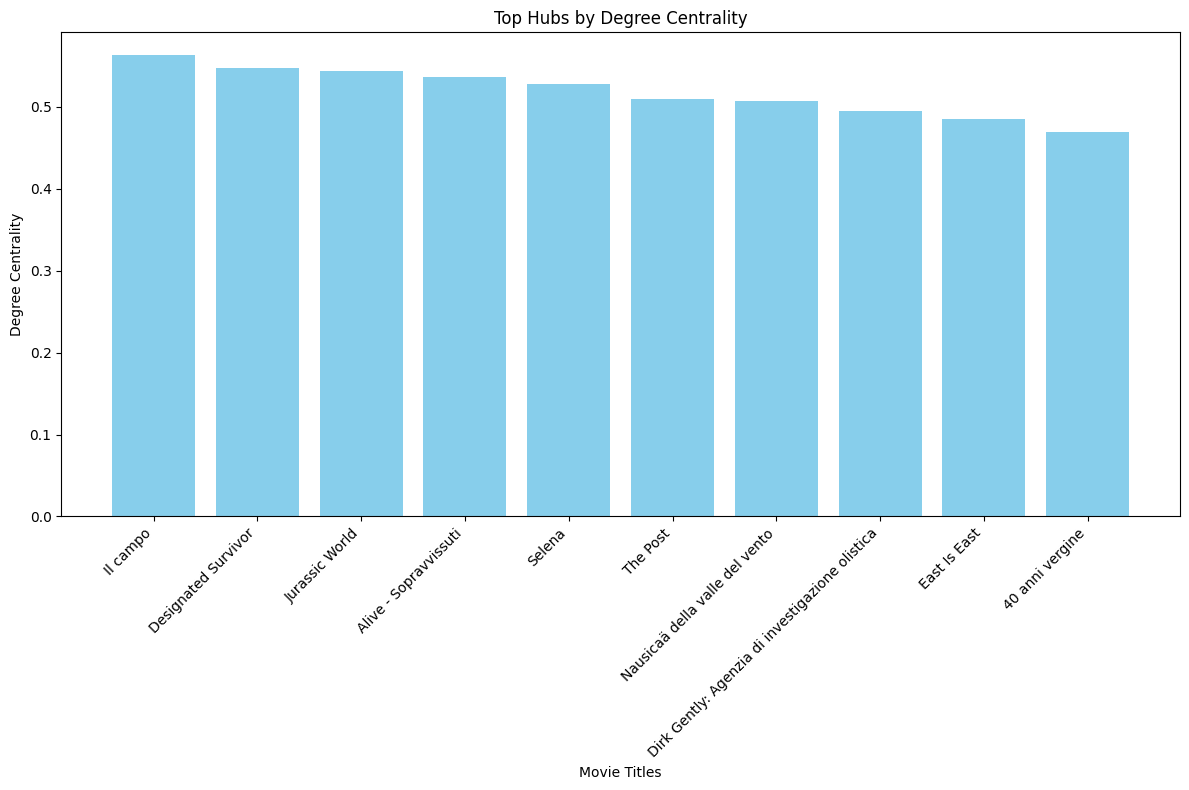

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(titles, centralities, color='skyblue')
plt.xlabel('Movie Titles')
plt.ylabel('Degree Centrality')
plt.title('Top Hubs by Degree Centrality')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Betweenness centrality

Nodes with the highest betweenness centrality appear on the most shortest paths between other nodes.

In [ ]:

betweenness_centrality = nx.betweenness_centrality(G)

# Sort nodes by betweenness centrality
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top N hubs
top_n = 10
top_betweenness_hubs = sorted_betweenness_centrality[:top_n]
betweenness_titles = []
betweenness_centralities = []

print("\nTop hubs by betweenness centrality:")
for node, centrality in top_betweenness_hubs:
    # Retrieve specific attributes
    title = G.nodes[node].get('title')
    betweenness_titles.append(title)
    betweenness_centralities.append(centrality)
    genre = G.nodes[node].get('genre')
    community = G.nodes[node].get('community')
    print(f"Node: {node}, Centrality: {centrality:.4f}, Title: {title}, Genre: {genre}, Community: {community}")



Top hubs by betweenness centrality:
Node: 276, Centrality: 0.0175, Title: Il campo, Genre: ['Drama', 'Thriller'], Community: 3
Node: 620, Centrality: 0.0172, Title: Jurassic World, Genre: ['Action', 'Adventure', 'Sci-Fi'], Community: 2
Node: 893, Centrality: 0.0171, Title: Designated Survivor, Genre: ['Action', 'Drama', 'Mystery'], Community: 2
Node: 613, Centrality: 0.0166, Title: Alive - Sopravvissuti, Genre: ['Adventure', 'Biography', 'Drama'], Community: 3
Node: 1355, Centrality: 0.0156, Title: Selena, Genre: ['Biography', 'Drama', 'Music'], Community: 0
Node: 790, Centrality: 0.0152, Title: The Post, Genre: ['Biography', 'Drama', 'History'], Community: 2
Node: 1566, Centrality: 0.0139, Title: Dirk Gently: Agenzia di investigazione olistica, Genre: ['Comedy', 'Mystery', 'Sci-Fi'], Community: 3
Node: 129, Centrality: 0.0138, Title: Nausicaä della valle del vento, Genre: ['Animation', 'Adventure', 'Fantasy'], Community: 1
Node: 796, Centrality: 0.0131, Title: Nikita, Genre: ['Action

There are high values of degree centrality but low values of betweenness. It means that these top nodes are connected to many other nodes directly, but are not frequently on the shortest paths between other nodes.
It means that these nodes acts as local hubs within their immediate neighborhood but do not serve as critical connectors between different neighborhoods or communities within the network.
Each node is likely part of a densely connected cluster or community. It has many direct connections within this cluster but does not facilitate communication between different clusters.

#### Closeness centrality

Nodes with high closeness centrality are close to all other nodes in terms of shortest paths.

In [ ]:
# Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Sort nodes by closeness centrality
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top N hubs
top_n = 10
top_closeness_hubs = sorted_closeness_centrality[:top_n]
closeness_titles = []
closeness_centralities = []

print("\nTop hubs by closeness centrality:")
for node, centrality in top_closeness_hubs:
    # Retrieve specific attributes
    title = G.nodes[node].get('title')
    closeness_titles.append(title)
    closeness_centralities.append(centrality)
    genre = G.nodes[node].get('genre')
    community = G.nodes[node].get('community')
    print(f"Node: {node}, Centrality: {centrality:.4f}, Title: {title}, Genre: {genre}, Community: {community}")



Top hubs by closeness centrality:
Node: 276, Centrality: 0.6957, Title: Il campo, Genre: ['Drama', 'Thriller'], Community: 3
Node: 893, Centrality: 0.6884, Title: Designated Survivor, Genre: ['Action', 'Drama', 'Mystery'], Community: 2
Node: 620, Centrality: 0.6866, Title: Jurassic World, Genre: ['Action', 'Adventure', 'Sci-Fi'], Community: 2
Node: 613, Centrality: 0.6833, Title: Alive - Sopravvissuti, Genre: ['Adventure', 'Biography', 'Drama'], Community: 3
Node: 1355, Centrality: 0.6792, Title: Selena, Genre: ['Biography', 'Drama', 'Music'], Community: 0
Node: 790, Centrality: 0.6708, Title: The Post, Genre: ['Biography', 'Drama', 'History'], Community: 2
Node: 129, Centrality: 0.6699, Title: Nausicaä della valle del vento, Genre: ['Animation', 'Adventure', 'Fantasy'], Community: 1
Node: 1566, Centrality: 0.6646, Title: Dirk Gently: Agenzia di investigazione olistica, Genre: ['Comedy', 'Mystery', 'Sci-Fi'], Community: 3
Node: 1014, Centrality: 0.6604, Title: East Is East, Genre: ['C

#### Eigenvector centrality

Nodes with high eigenvector centrality are connected to other high-scoring nodes.


In [ ]:
import networkx as nx

# Compute eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sort nodes by eigenvector centrality
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top N hubs
top_n = 10
top_eigenvector_hubs = sorted_eigenvector_centrality[:top_n]
eigenvector_titles = []
eigenvector_centralities = []

print("\nTop hubs by eigenvector centrality:")
for node, centrality in top_eigenvector_hubs:
    # Retrieve specific attributes
    title = G.nodes[node].get('title')
    eigenvector_titles.append(title)
    eigenvector_centralities.append(centrality)
    genre = G.nodes[node].get('genre')
    community = G.nodes[node].get('community')
    print(f"Node: {node}, Centrality: {centrality:.4f}, Title: {title}, Genre: {genre}, Community: {community}")



Top hubs by eigenvector centrality:
Node: 276, Centrality: 0.1015, Title: Il campo, Genre: ['Drama', 'Thriller'], Community: 3
Node: 893, Centrality: 0.0970, Title: Designated Survivor, Genre: ['Action', 'Drama', 'Mystery'], Community: 2
Node: 613, Centrality: 0.0964, Title: Alive - Sopravvissuti, Genre: ['Adventure', 'Biography', 'Drama'], Community: 3
Node: 620, Centrality: 0.0961, Title: Jurassic World, Genre: ['Action', 'Adventure', 'Sci-Fi'], Community: 2
Node: 1355, Centrality: 0.0946, Title: Selena, Genre: ['Biography', 'Drama', 'Music'], Community: 0
Node: 129, Centrality: 0.0937, Title: Nausicaä della valle del vento, Genre: ['Animation', 'Adventure', 'Fantasy'], Community: 1
Node: 790, Centrality: 0.0911, Title: The Post, Genre: ['Biography', 'Drama', 'History'], Community: 2
Node: 1566, Centrality: 0.0886, Title: Dirk Gently: Agenzia di investigazione olistica, Genre: ['Comedy', 'Mystery', 'Sci-Fi'], Community: 3
Node: 1014, Centrality: 0.0877, Title: East Is East, Genre: [

### Communities statistics

#### Modularity

In [ ]:
modularity = community_louvain.modularity(louvain_partition0,G,weight = 'weight')
modularity

0.2792661326483085

 It indicates a weaker community structure where there are still identifiable communities, but many edges exist between different communities.

### Hubs in each community

In [ ]:
import networkx as nx
import pandas as pd
from collections import defaultdict


# Function to get hubs in each community
def get_hubs_by_community(graph):
    # Group nodes by community
    communities = defaultdict(list)
    for node, data in graph.nodes(data=True):
        communities[data['community']].append(node)

    hubs = []



    # Calculate degree centrality for nodes in each community
    for community, nodes in communities.items():
        subgraph = graph.subgraph(nodes)
        degree_centrality = nx.degree_centrality(subgraph)
        # Find the node with highest degree centrality
        max_centrality = max(degree_centrality.values())
        hub_nodes = [node for node, centrality in degree_centrality.items() if centrality == max_centrality]


        for hub in hub_nodes:
            hubs.append({
                'title': subgraph.nodes[hub]['title'],
                'genre': subgraph.nodes[hub]['genre'],
                'community': subgraph.nodes[hub]['community'],
                'degree_centrality': max_centrality
            })

    return sorted(hubs, key=lambda x: x['community'], reverse=False)

hubs= get_hubs_by_community(G)

df_hubs= pd.DataFrame(hubs)
df_hubs


title                                 genre  community  \
0                 Selena       ['Biography', 'Drama', 'Music']          0   
1  A casa per le vacanze        ['Comedy', 'Drama', 'Romance']          1   
2               The Post     ['Biography', 'Drama', 'History']          2   
3      A casa per Natale                  ['Comedy', 'Family']          3   
4              Bee Movie  ['Animation', 'Adventure', 'Comedy']          4   
5              Studio 54                    ['Drama', 'Music']          5   

   degree_centrality  
0           0.667763  
1           0.584475  
2           0.598485  
3           0.692935  
4           0.572289  
5           0.424490

### Number of different genres in each community

In [ ]:
df = pd.read_csv('IMDB_movie_details.csv')
df.head()

movie_id                                       plot_summary  duration  \
0  tt0105112  Former CIA analyst, Jack Ryan is in England wi...  1h 57min   
1  tt1204975  Billy (Michael Douglas), Paddy (Robert De Niro...  1h 45min   
2  tt0243655  The setting is Camp Firewood, the year 1981. I...  1h 37min   
3  tt0040897  Fred C. Dobbs and Bob Curtin, both down on the...   2h 6min   
4  tt0126886  Tracy Flick is running unopposed for this year...  1h 43min   

                               genre  rating release_date  \
0             ['Action', 'Thriller']     6.9   1992-06-05   
1                         ['Comedy']     6.6   2013-11-01   
2              ['Comedy', 'Romance']     6.7   2002-04-11   
3  ['Adventure', 'Drama', 'Western']     8.3   1948-01-24   
4     ['Comedy', 'Drama', 'Romance']     7.3   1999-05-07   

                                       plot_synopsis  \
0  Jack Ryan (Ford) is on a "working vacation" in...   
1  Four boys around the age of 10 are friends in ...   
2                                                NaN   
3  Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...   
4  Jim McAllister (Matthew Broderick) is a much-a...   

                          title  
0              Giochi di potere  
1                    Last Vegas  
2       Wet Hot American Summer  
3  Il tesoro della Sierra Madre  
4                      Election

In [ ]:
communities= [nodes[f'{i}']['community'] for i in range(len(df))]
df['community']= communities

In [ ]:
df.head()

movie_id                                       plot_summary  duration  \
0  tt0105112  Former CIA analyst, Jack Ryan is in England wi...  1h 57min   
1  tt1204975  Billy (Michael Douglas), Paddy (Robert De Niro...  1h 45min   
2  tt0243655  The setting is Camp Firewood, the year 1981. I...  1h 37min   
3  tt0040897  Fred C. Dobbs and Bob Curtin, both down on the...   2h 6min   
4  tt0126886  Tracy Flick is running unopposed for this year...  1h 43min   

                               genre  rating release_date  \
0             ['Action', 'Thriller']     6.9   1992-06-05   
1                         ['Comedy']     6.6   2013-11-01   
2              ['Comedy', 'Romance']     6.7   2002-04-11   
3  ['Adventure', 'Drama', 'Western']     8.3   1948-01-24   
4     ['Comedy', 'Drama', 'Romance']     7.3   1999-05-07   

                                       plot_synopsis  \
0  Jack Ryan (Ford) is on a "working vacation" in...   
1  Four boys around the age of 10 are friends in ...   
2                                                NaN   
3  Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...   
4  Jim McAllister (Matthew Broderick) is a much-a...   

                          title  community  
0              Giochi di potere          0  
1                    Last Vegas          0  
2       Wet Hot American Summer          1  
3  Il tesoro della Sierra Madre          3  
4                      Election          0

In [ ]:
df['genre'] = df['genre'].apply(ast.literal_eval)

In [ ]:
from collections import Counter

def top_genres_per_community(df, top_n=3):
    # Group by community
    community_groups = df.groupby('community')

    # Dictionary to hold the top genres for each community
    top_genres = {}

    # Iterate over each community group
    for community, group in community_groups:
        # Flatten the list of genres in the community
        all_genres = [genre for sublist in group['genre'] for genre in sublist]

        # Count the frequency of each genre
        genre_counts = Counter(all_genres)
        print(genre_counts)


        # Get the top N genres
        most_common_genres = genre_counts.most_common(top_n)

        # Store in the dictionary
        top_genres[community] = most_common_genres

    return top_genres

# Get the top 3 genres for each community
top_genres = top_genres_per_community(df, top_n=5)
print(top_genres)

Counter({'Drama': 166, 'Comedy': 163, 'Romance': 81, 'Crime': 32, 'Thriller': 31, 'Adventure': 31, 'Action': 30, 'Horror': 25, 'Mystery': 24, 'Family': 23, 'Fantasy': 22, 'Biography': 20, 'Music': 18, 'Sport': 15, 'Sci-Fi': 12, 'Animation': 5, 'Musical': 4, 'History': 2, 'War': 1})
Counter({'Drama': 123, 'Comedy': 110, 'Romance': 51, 'Crime': 47, 'Adventure': 38, 'Family': 36, 'Action': 35, 'Mystery': 25, 'Thriller': 20, 'Fantasy': 19, 'Horror': 13, 'Biography': 12, 'Animation': 9, 'Music': 8, 'Sci-Fi': 6, 'Sport': 4, 'Musical': 1, 'History': 1, 'War': 1})
Counter({'Action': 163, 'Adventure': 152, 'Sci-Fi': 99, 'Drama': 95, 'Thriller': 55, 'Comedy': 36, 'Fantasy': 25, 'History': 23, 'Mystery': 20, 'War': 17, 'Crime': 16, 'Biography': 14, 'Horror': 13, 'Romance': 13, 'Animation': 9, 'Family': 5, 'Western': 2, 'Music': 2, 'Film-Noir': 1, 'Sport': 1})
Counter({'Drama': 205, 'Crime': 168, 'Action': 123, 'Thriller': 90, 'Comedy': 84, 'Adventure': 61, 'Mystery': 53, 'Sci-Fi': 41, 'Biography'

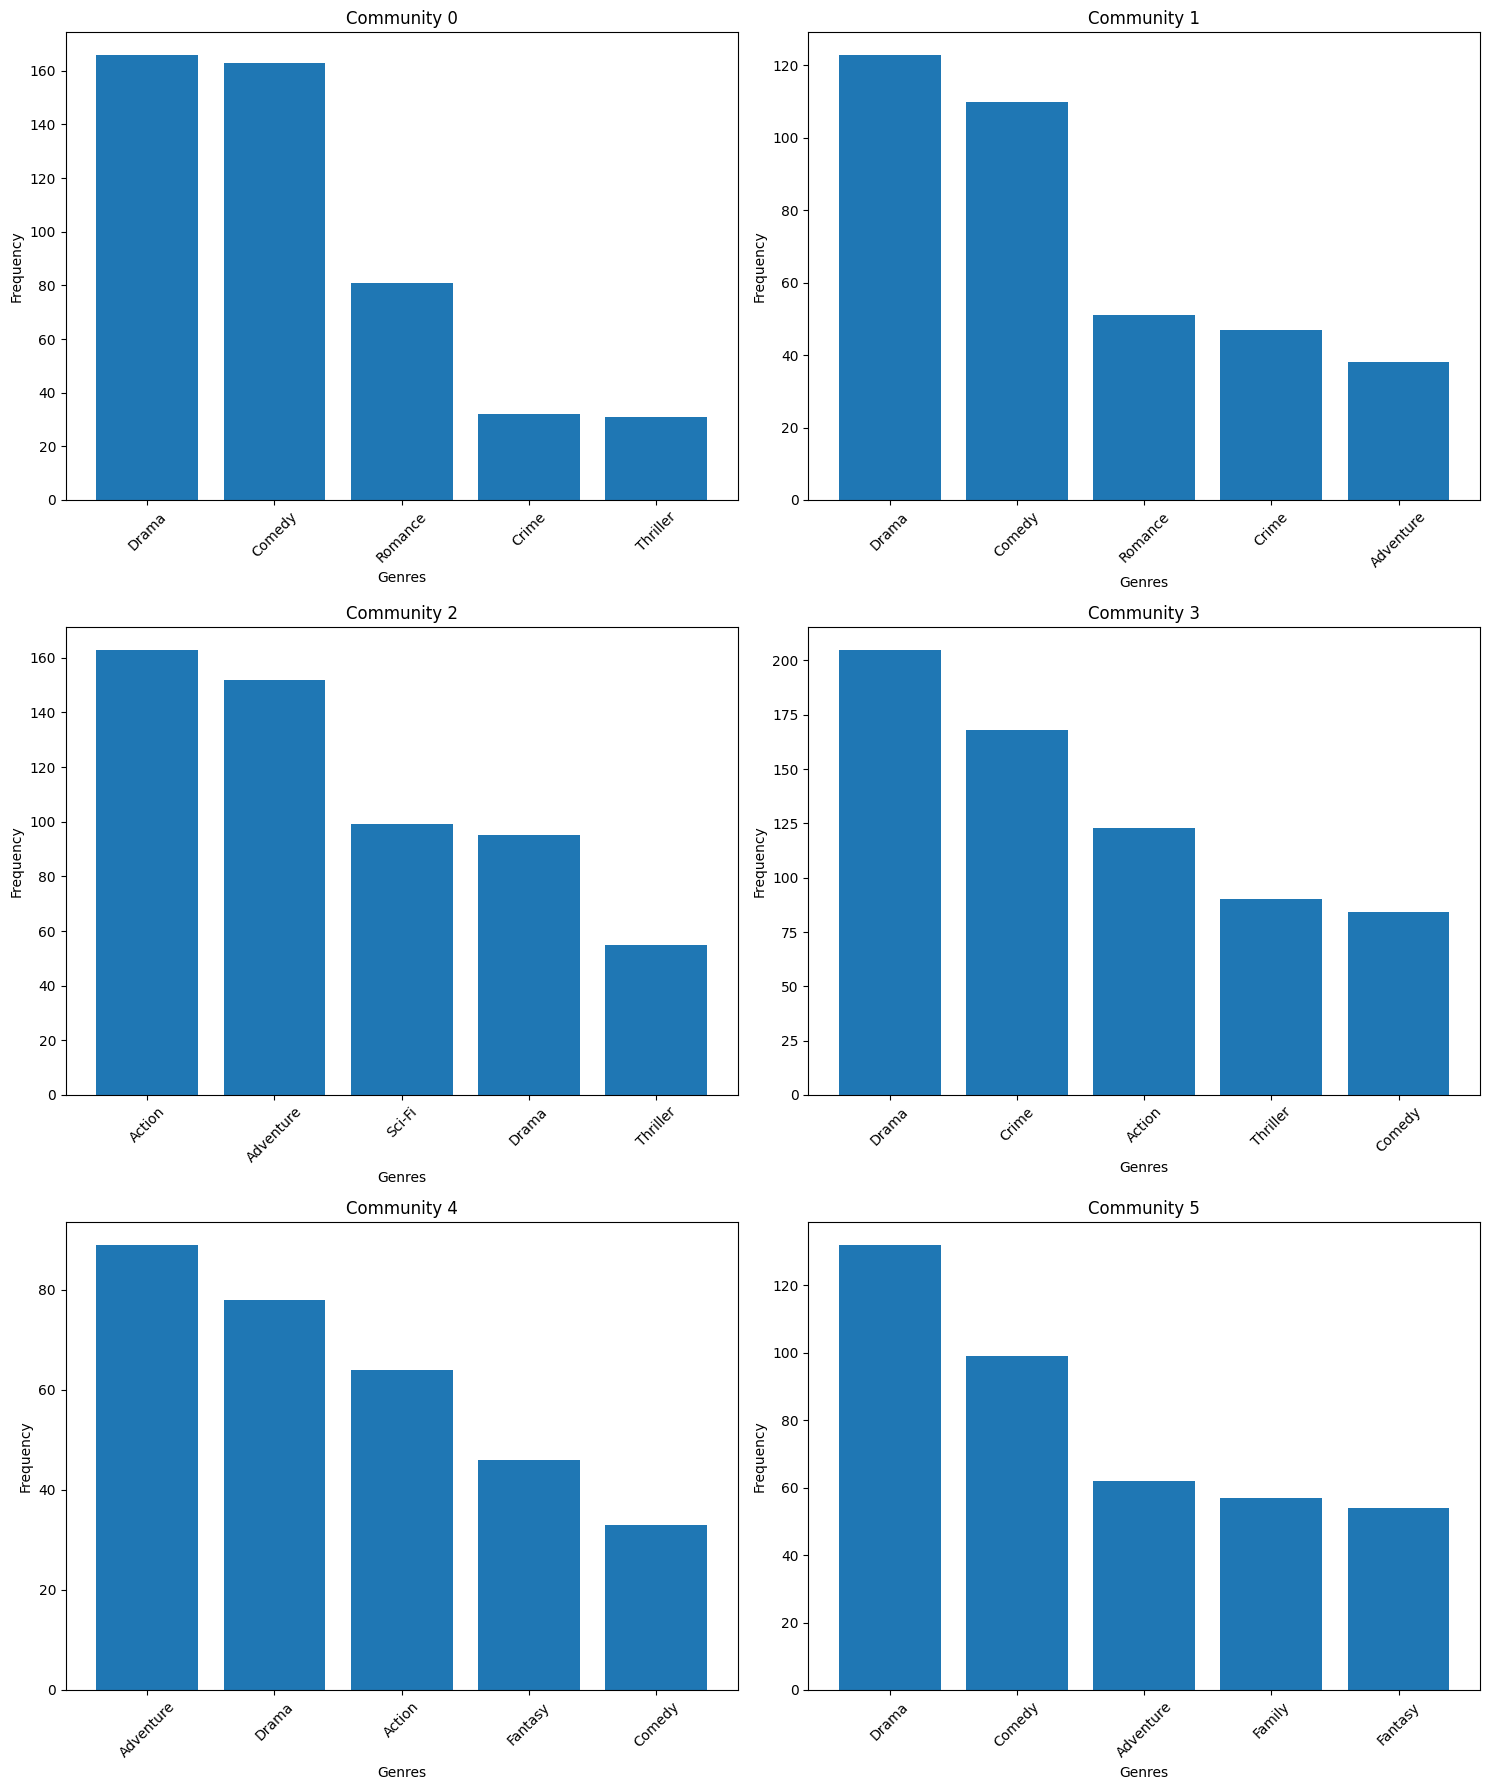

In [ ]:

fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plotting each community's genre frequencies
for i, (community, genres) in enumerate(top_genres.items()):
    genres, counts = zip(*genres)
    axes[i].bar(genres, counts)
    axes[i].set_title(f'Community {community}')
    axes[i].set_xlabel('Genres')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
